## 第一次讀書會-第3組

### 對ptt數位中介服務法爭議事件進行情緒分析。

- 課程：社群媒體分析
- 授課教授：黃三益
- 組長：B084020041劉怡謙
- 組員：B094020042黃萱妮、B084020009程尤欣、M114020052王渙鈞、姚昀誠、劉杰煊、B065040041蔡瑋駿、M114020055吳均庭

## Outline
- 1. About data
    - 1.1 資料基本介紹
    - 1.2 分析方向
    - 1.3 事件始末
- 2. 資料前處理
    - 2.1 資料讀取
    - 2.2 資料清理
    - 2.3 斷詞及停用字處理
      - 2.3.1 根據需求手動加入字詞
      - 2.3.2 根據需求手動加入停用字
    - 2.4 計算及記錄詞頻
    - 2.5 lexicon-base 情緒分析
      - 2.5.1 根據需求手動修正情緒字彙
- 3. 文章內容分析
    - 3.1 內文詞頻分析
    - 3.2 觀察發文頻率
    - 3.3 文章正負面情緒分數分析
    - 3.4 內文文字雲
- 4. 留言內容分析
    - 4.1 留言詞頻分析
    - 4.2 觀察留言頻率
    - 4.3 留言正負面情緒分數分析
    - 4.4 留言文字雲
    - 4.5 留言正負面情緒總量及代表字
- 5. 大量噓文文章相關分析
- 6. 結論與討論

In [1]:
from datetime import datetime
from collections import Counter
from PIL import Image, ImageSequence

import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
import numpy as np
from tqdm import tqdm

from matplotlib.colors import Colormap
from wordcloud import WordCloud, ImageColorGenerator
import jieba
%matplotlib inline

In [2]:
# plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
from matplotlib.font_manager import FontProperties
myfont =  FontProperties(fname = r'C:\Users\user\anaconda3\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\SimHei.ttf')
plt.rcParams['font.sans-serif'] = ['SimHei']

fprop = fm.FontProperties(fname="./SourceHanSansTW-Regular.otf")
fprop
# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

# 1. About data
#### 1.1 資料基本介紹
- 資料來源：文字平台收集PTT Gossip版2022-01-01 ~ 2023-03-15與《數位中介服務法》相關的文章
- 搜尋關鍵字：'數位中介'、'中介法'、'數位中介法'、'數位中介服務法'。
- 排除關鍵字：'全動'、'全動法'、'選罷法'。
- 情緒字典：採用NTUSD(台大)情緒字典。
- 斷詞字典：自定義13個項目("言論自由","數位中介服務法", "中介法", "主管機關"...)
- 資料時間：2022-01-01 ~ 2023-03-15

#### 1.2 主要分析ptt上文章內容及網友相關討論。本次主要針對以下方向分析：
1. 《數位中介服務法》主要發文及討論時間點，以及話題高峰所在。
2. 《數位中介服務法》相關文章的討論內容為何。
3. 《數位中介服務法》相關文章下，留言(推噓文)討論內容為何及留言(推噓文)相關情緒字彙。
4. 《數位中介服務法》相關文章中，獲得大量噓文的文章內容及留言(推噓文)內容為何。 

#### 1.3 事件始末：
1. 2022/06/29 國家通訊傳播委員會(NCC)提出《數位中介服務法》草案。
2. 2022/07/28 立法院資策會召開首次《數位中介服務法》公聽會，會後各界憂心該法可能對言論自由造成威脅。
3. 2022/08/18 召開《數位中介服務法》第三場公開說明會，與資訊儲存服務及線上平臺服務業者進行說明及討論。同日，PTT法務部顧問於會後受訪時表示「該法通過就跟逼我們關站並無不同」，台灣著名網路論壇與新聞網站「巴哈姆特電玩資訊站」站長也透過個人網誌表達反對《數位中介服務法》，在PTT引發大量爭議及討論。
4. 2022/08/19 NCC宣布原定2022/08/25舉辦召開的公聽會延後召開，行政院長蘇貞昌表示會在與各界溝通協商後再進行修法。

**資訊來源**：Wikipedia及個人整理<br>

## 2. 資料前處理
### 2.1 資料讀取

In [3]:
#讀取ptt資料
df = pd.read_csv('data.csv')
df = df.rename(columns={"artContent": "sentence"})
print(f"ptt共有 {df.shape[0]} 篇文章") 

ptt共有 1757 篇文章


In [4]:
#讀取ptt留言資料
cmdf = pd.read_csv('comment.csv')
print(f"ptt共有 {cmdf.shape[0]} 篇留言") #(row,column)

ptt共有 154732 篇留言


### 2.2 資料清理
- 去除NA值
- 正規化資料清理
- 去除不是中文的字詞

In [5]:
#清理文章內容
clear_df = df.copy()
#去除有包含空值的筆數
clear_df.dropna(axis = 0, how = 'any', inplace = True)
#用'。'取代'\n\n'，並移除'\n'
clear_df = clear_df.replace(r'\\n\\n', '。', regex = True).replace(r'\n', '', regex = True)

#移除內文中的網址
clear_df['sentence'] = (
    clear_df['sentence']
    .replace(r'http\S+', '', regex = True)
    .replace(r'www\S+', '', regex = True)
    .replace(r'\d+', '', regex = True)
)
#清理符號
clear_df['sentence'] = clear_df['sentence'].astype(str).str.split("[,，。！!？?]{1,}")
sent_df = clear_df.explode("sentence").reset_index(drop=True)
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

#對文章內容做處裡
sent_df["sentence"] = (
    sent_df["sentence"].str.replace(r"[^\w\s\d]+", "", regex=True).astype(str)
)
sent_df = sent_df[sent_df["sentence"].str.len() > 1]


In [6]:
#清理留言內容
clear_cmdf = cmdf.copy()
#去除有包含空值的筆數
clear_cmdf.dropna(axis = 0, how = 'any', inplace = True)
#用'。'取代'\n\n'，並移除'\n'
clear_cmdf = clear_cmdf.replace(r'\\n\\n', '。', regex = True).replace(r'\n', '', regex = True)

#移除留言中的網址
clear_cmdf['cmtContent'] = (
    clear_cmdf['cmtContent']
    .replace(r'http\S+', '', regex = True)
    .replace(r'www\S+', '', regex = True)
)
#清理符號
clear_cmdf['cmtContent'] = clear_cmdf['cmtContent'].astype(str).str.split("[,，。！!？?]{1,}")
sent_cmdf = clear_cmdf.explode("cmtContent").reset_index(drop=True)
sent_cmdf = sent_cmdf[sent_cmdf["cmtContent"].str.len() > 1]

#對留言內容做處理
sent_cmdf['cmtContent'] = (
    sent_cmdf['cmtContent'].str.replace(r"[^\w\s\d]+", "", regex=True).astype(str)
)
sent_cmdf = sent_cmdf[sent_cmdf['cmtContent'].str.len() > 1]


### 2.3 斷詞及停用字處理

我們使用jieba套件進行斷詞與移除停用字

In [7]:
#設定繁體中文詞庫
jieba.set_dictionary("dict/dict.txt")
#新增自定義字典
jieba.load_userdict("dict/user_dict.txt")

Building prefix dict from C:\Users\user\Desktop\中山\大四\四下\社媒分析\Group3_Project1\dict\dict.txt ...
Dumping model to file cache C:\Users\user\AppData\Local\Temp\jieba.u723b4ad8b1055db8be92784e78f046b1.cache
Loading model cost 0.631 seconds.
Prefix dict has been built successfully.


### 2.3.1 根據需求手動加入字詞
閱讀相關新聞及觀察資料後，得知《數位中介服務法》主要的討論議題可能集中在言論自由、政府單位越權疑慮等內容。進而衍生出嘲諷或辱罵執政黨等相關字詞。故在自定義字典中加入相關詞彙以聚焦討論內容。

#### 新增詞彙表：
["言論自由","數位中介服務法", "中介法", "主管機關", "推文違反數位中介法", "行政機關", "已被刪除","党","黨", "綠色恐怖", "支持者", "好了啦", "完全執政"]

#### 新增詞彙說明:
推文違反數位中介法、已被刪除: 該時期八卦版使用者常在數位中介法相關討論文章留下《此推文違反數位中介法已被刪除》、用以諷刺該法案。<br>
綠色恐怖: 因該法案有限制言論自由之疑慮，便以"白色恐怖"的變體來嘲諷推行該法案的執政黨。<br>
党、黨 : 用以嘲諷此法案通過將如同中國進行言論管制，故以簡體字"党"戲稱之。<br>

In [8]:
#對文章內容進行斷詞處理
word_df = (
    sent_df.assign(word=sent_df["sentence"].apply(jieba.lcut))
    .explode("word")
    .drop(["sentence"], axis=1)
)
word_df = word_df.loc[word_df["word"].str.len() > 1]

#對留言內容進行斷詞處理
word_cmdf = (
    sent_cmdf.assign(word=sent_cmdf['cmtContent'].apply(jieba.lcut))
    .explode("word")
    .drop(['cmtContent'], axis=1)
)
word_cmdf = word_cmdf.loc[word_cmdf["word"].str.len() > 1]

### 2.3.2 根據需求手動加入停用字
刪除透過APP發文產生的無用字詞及PTT八卦版發文者常用的無意義用詞等(ex:"有沒有XXX的八卦"中的 "有沒有")

#### 新增停用字表：
["my","JPTT", "from", "on", "send", "Sent", "PTT","iPhone","今天", "一下", "一堆", "有沒有", "ptt"]

In [9]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [
    line.strip()
    for line in open("dict/stopwords.txt", "r", encoding="utf-8").readlines()
]

#處理過停用字後的文章內容
noStop_df = word_df[~word_df["word"].isin(stopwords)]
#處理過停用字後的留言內容
noStop_cmdf = word_cmdf[~word_cmdf["word"].isin(stopwords)]

### 2.4 計算及記錄詞頻

計算字詞出現相關頻率以利分析。

In [10]:
#紀錄文章中字詞出現頻率
noStop_df["word"].value_counts().to_csv("./freq.csv")
#紀錄留言中字詞出現頻率
noStop_cmdf["word"].value_counts().to_csv("./Commentfreq.csv")

### 2.5 lexicon-base 情緒分析

- 進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併。

In [11]:
#讀取NTUSD情緒字典
filepath = ['negative', 'positive']
d_liwc = []
for file in filepath:
    filename = f"./dict/liwc/NTUSD/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([f.read().split("\n"),file])

df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_liwc

,word,sentiments
0,幹,negative
1,一下子爆發,negative
2,一下子爆發的一連串,negative
3,一巴掌,negative
4,一再,negative
...,...,...
11083,戀戀,positive
11084,驚喜,positive
11085,讚許,positive
11086,讚賞,positive


### 2.5.1 根據需求手動修正情緒字彙

觀察資料及情緒字典後發現文章及留言中常出現的字詞，可能不具備情緒字典中設定的情緒。<br>
例如文章及留言中出現度極高的"自由"，應是表達"言論自由"的部分，而不具備正向情緒。<br>
同理，"笑死"、"好笑"具有嘲諷、無奈等意味；"進步"應是指"民主進步黨"；"嘻嘻"則為八卦版友常見語助詞；"法律"、"知道"在此應多是中性詞。<br>
經判斷後認為以上皆不具有正面情緒，故從情緒字典中移除。


In [12]:
#根據需求修正情緒字典
df_liwc = df_liwc.drop(
    df_liwc[(df_liwc.word == '自由')|(df_liwc.word == '笑死')|(df_liwc.word == '好笑')|(df_liwc.word == '嘻嘻')|
            (df_liwc.word == '進步')|(df_liwc.word == '法律')|(df_liwc.word == '知道')].index ,axis=0)

df_liwc['sentiments'].value_counts() 

negative    8278
positive    2802
Name: sentiments, dtype: int64

## 3. 文章內容分析(常見字詞、發文頻率、正負情緒分析、文字雲)

### 3.1 內文詞頻分析
首先觀察相關文章中出現率最高的字詞

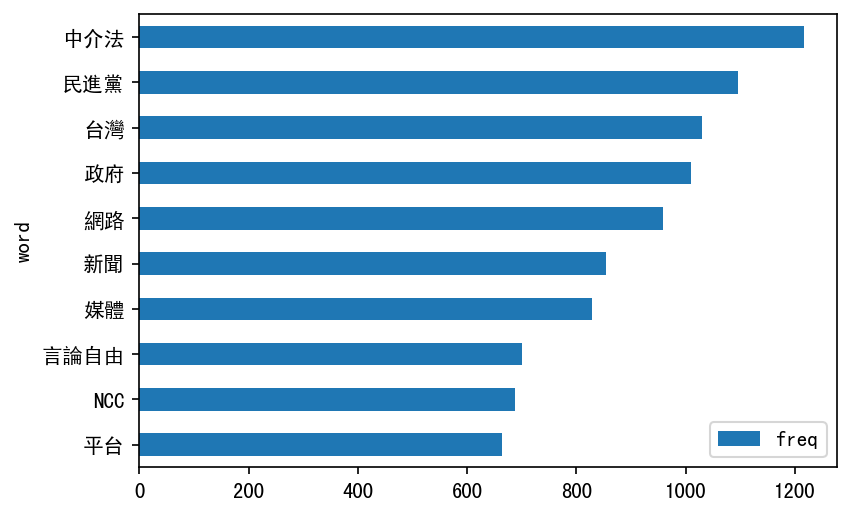

In [13]:
#文章詞頻
art_freq_df = pd.DataFrame({'freq':noStop_df.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)
art_list = ['word','freq']
art_freq_df = art_freq_df[art_list]

#依文章詞頻製圖
art_freq_df.iloc[:10].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

由上圖可見，文章中最常出現的詞彙分別為與《數位中介服務法》相關的"中介法"、"數位"；與媒體及言論自由相關的"網路"、"新聞"、"媒體"等字<br>
以及與法案推行相關的"政府"、"NCC"、"民進黨"等字。

故推測文章內容主要以中介法、可能受影響的範圍及執政黨和及政府相關單位為主。

### 3.2 觀察發文頻率
透過觀察發文頻率以找出引起最多討論的時期。

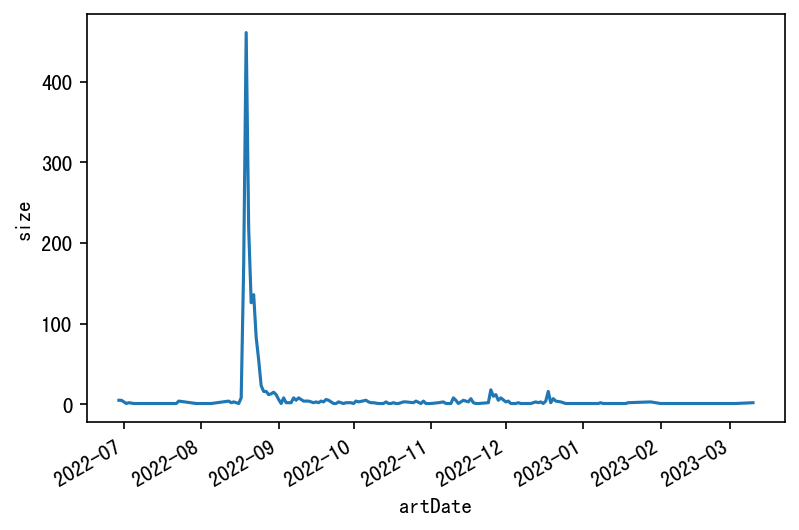

In [14]:
#各日文章數量
ptt_df_date = df.copy()
#只看日期，不抓時間
ptt_df_date['artDate'] = pd.Series.to_frame(ptt_df_date["artDate"])
ptt_df_date["artDate"].describe(datetime_is_numeric=True)
ptt_df_date["artDate"] = pd.to_datetime(ptt_df_date["artDate"]).dt.date

#畫圖
pttdatefq_line_plot = ptt_df_date.groupby(["artDate"], as_index=False).size()
fig, ax = plt.subplots()

ax.plot(pttdatefq_line_plot["artDate"], pttdatefq_line_plot["size"])
ax.set_xlabel("artDate")
ax.set_ylabel('size')
fig.autofmt_xdate()
plt.show()


由圖可見，發文數最多的時間點集中在2022年八月中左右。

### 3.3 文章正負面情緒分數分析
透過正負面情緒分數來了解發文者對中介法相關議題的情緒。

In [15]:
#將情緒字典與斷詞結果進行合併
ptt_df_nostop = noStop_df.copy()
ptt_df_nostop['artDate'] = pd.Series.to_frame(noStop_df["artDate"])
ptt_df_nostop["artDate"].describe(datetime_is_numeric=True)
ptt_df_nostop["artDate"] = pd.to_datetime(noStop_df["artDate"]).dt.date

ptt_liwc_df = pd.merge(ptt_df_nostop[["artDate", "artUrl", "word"]], df_liwc, how="left")

In [16]:
#計算每日正負面及中立字詞數
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"], dropna=False, as_index=False).size()
)
sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])

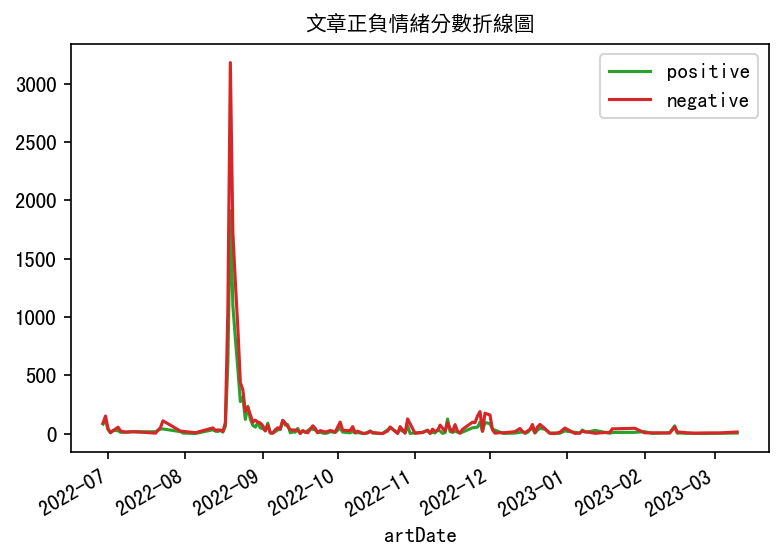

In [17]:
#依照上述內容繪製正負面情緒分數折線圖
colors = ["tab:green", "tab:red"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()

plt.title("文章正負情緒分數折線圖", 
          fontproperties=fprop)
plt.show()

經折線圖大略可知負面情緒高於正面情緒，但細部辨識有難度，故繪製比例折線圖以利觀察。

Text(0.5, 1.0, '文章正負情緒比例折線圖')

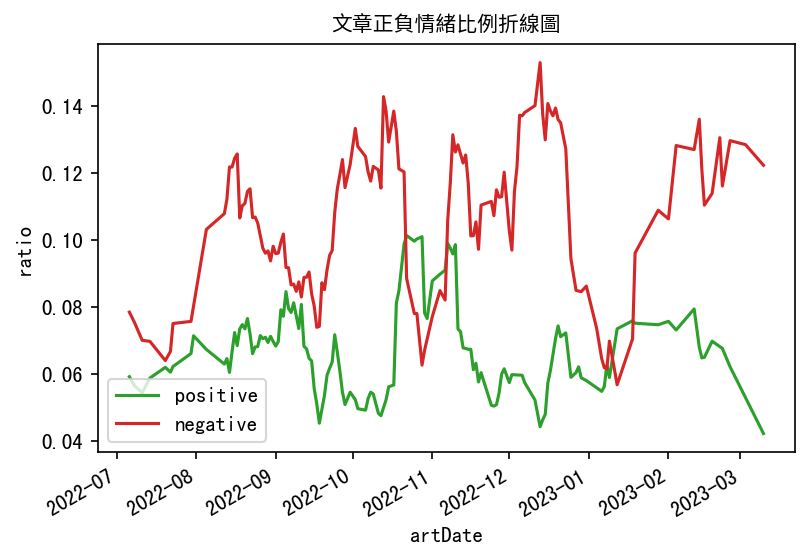

In [18]:
#正負向情緒分數比例折線圖
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

fig, ax = plt.subplots()

rolling_days = 7
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("文章正負情緒比例折線圖", fontproperties=fprop)

由圖可見，負面情緒分數多數時刻高於正面情緒分數，而發文頻率最高、討論最熱烈的八月中負面情緒分數也大幅超過正面情緒分數。<br>
##### 故推測《數位中介服務法》相關發文內容多抱持負面態度。

### 3.4 內文文字雲

接著透過文字雲分析文章內容及常出現的正負面情緒詞彙

In [19]:
#擷取正面
mask = sentiment_count['sentiments'] == 'positive'
sentiment_count.loc[mask,:].sort_values("size", ascending=False).head()

,artDate,sentiments,size,ratio
70,2022-08-19,positive,1910,0.068742
73,2022-08-20,positive,1100,0.068978
76,2022-08-21,positive,817,0.068575
67,2022-08-18,positive,600,0.066174
79,2022-08-22,positive,555,0.063349


In [20]:
#擷取負面
mask = sentiment_count['sentiments'] == 'negative'
sentiment_count.loc[mask,:].sort_values("size", ascending=False).head()

,artDate,sentiments,size,ratio
69,2022-08-19,negative,3182,0.114522
72,2022-08-20,negative,1727,0.108296
75,2022-08-21,negative,1298,0.108947
66,2022-08-18,negative,1057,0.116577
78,2022-08-22,negative,910,0.103869


觀察到資料中以8/18~8/22正負情緒詞彙為最多，與發文頻率相符合。時間上也吻合第三場公開說明會、引起PTT大量討論的時間點。故下方討論聚焦該段時期進行分析。

In [21]:
#選擇大量討論時間 2022/08/18~2022/08/22
mask = ((ptt_liwc_df['artDate'] == pd.Timestamp("2022-08-18"))|
        (ptt_liwc_df['artDate'] == pd.Timestamp("2022-08-19"))|
        (ptt_liwc_df['artDate'] == pd.Timestamp("2022-08-20"))|
        (ptt_liwc_df['artDate'] == pd.Timestamp("2022-08-21"))|
        (ptt_liwc_df['artDate'] == pd.Timestamp("2022-08-22")))

ptt_liwc_df = ptt_liwc_df.loc[mask, ["artDate", "word", "sentiments"]]

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


(-0.5, 1811.5, 1359.5, -0.5)

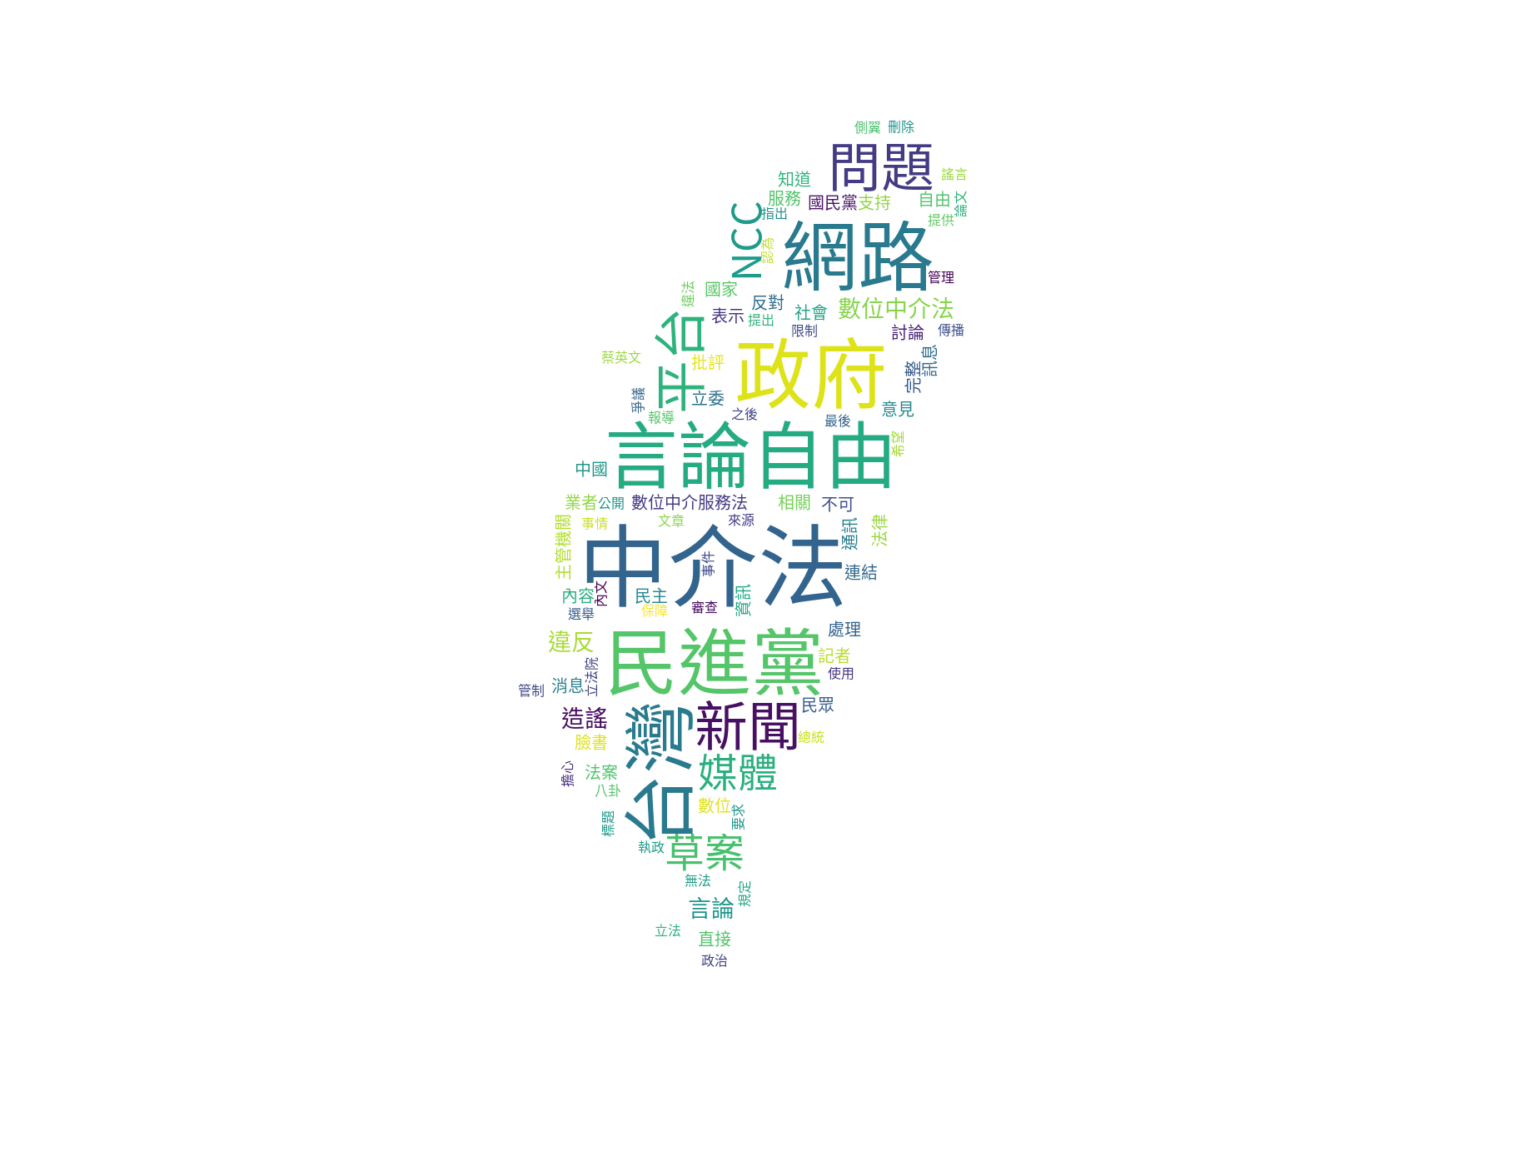

In [22]:
#繪製文字雲
wc = ptt_liwc_df.groupby(["word"]).size().to_dict()
Counter(wc).most_common(50)

#自訂文字雲圖形
mask_tw = np.array(Image.open("./pic/taiwan_mask.jpg"))

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path,mask = mask_tw, 
                  width = 1600, height = 800)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(20, 10), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()


 由文字雲可見，2022/8/18~8/22文章內容主要可大略分為以下幾類:
 - 該法案相關的"中介法"、"數位中介服務法"、"草案"、"數位"等
 - 推行該法案的"政府"、"民進黨"、"NCC"等
 - 受該法案影響者，如"平台"、"媒體"、"網路"、"記者"、"臉書"等

(-0.5, 1811.5, 1359.5, -0.5)

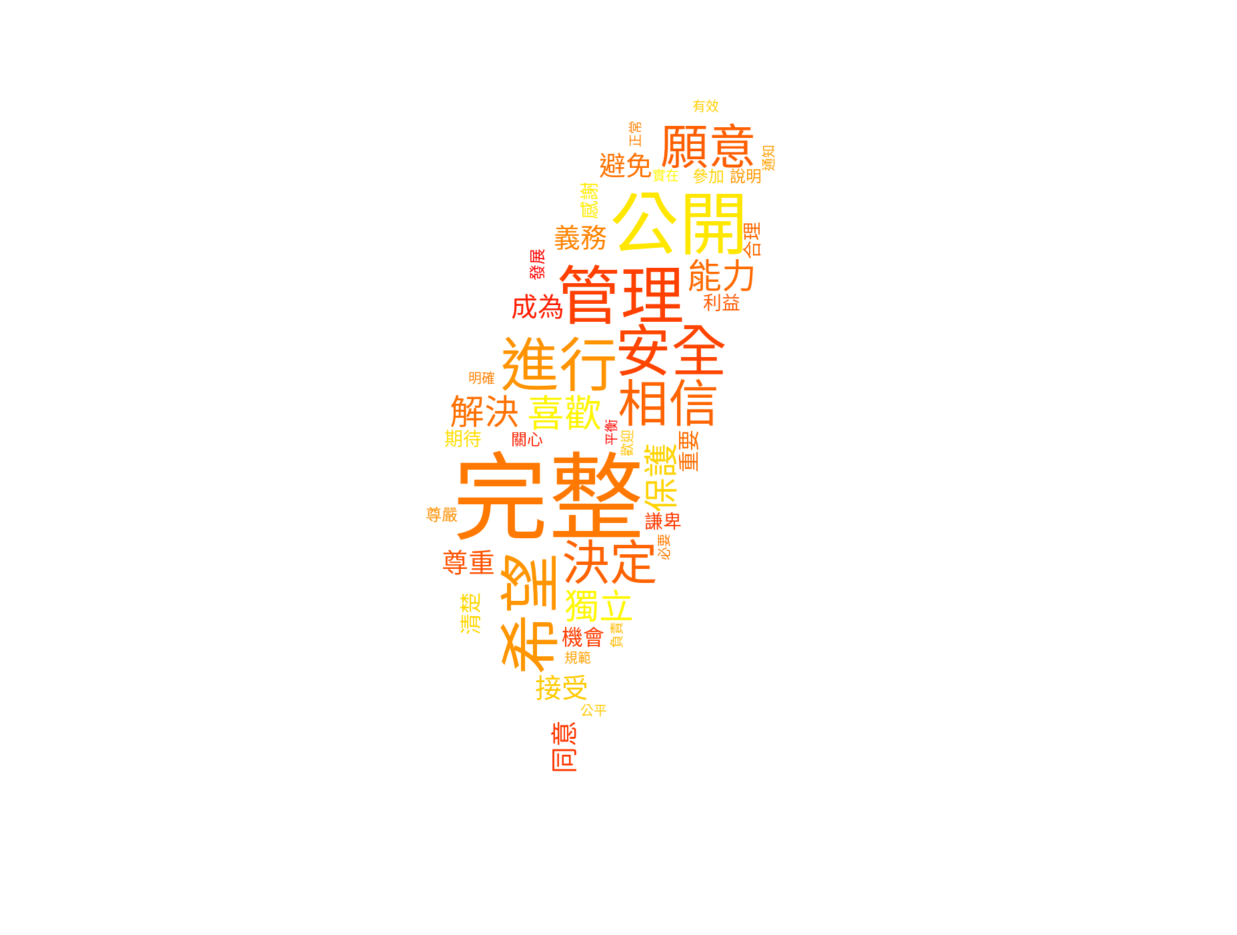

In [23]:
#正面
mask = (ptt_liwc_df["sentiments"] == "positive")

ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(50)


mask_tw = np.array(Image.open("./pic/taiwan_mask.jpg"))

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path, colormap="autumn",
                  mask = mask_tw,width=2000, height = 1000)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(16, 8), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

正面詞彙文字雲中，常出現"希望"、"完整"、"相信"等詞彙。<br>
觀察資料後發現，正面詞彙部分與新聞報導相關用語重複(ex:希望與各界多方討論、公開透明等)。而部分詞彙在文章內容中多為描述或中性詞(ex:管理、進行等)。

(-0.5, 1811.5, 1359.5, -0.5)

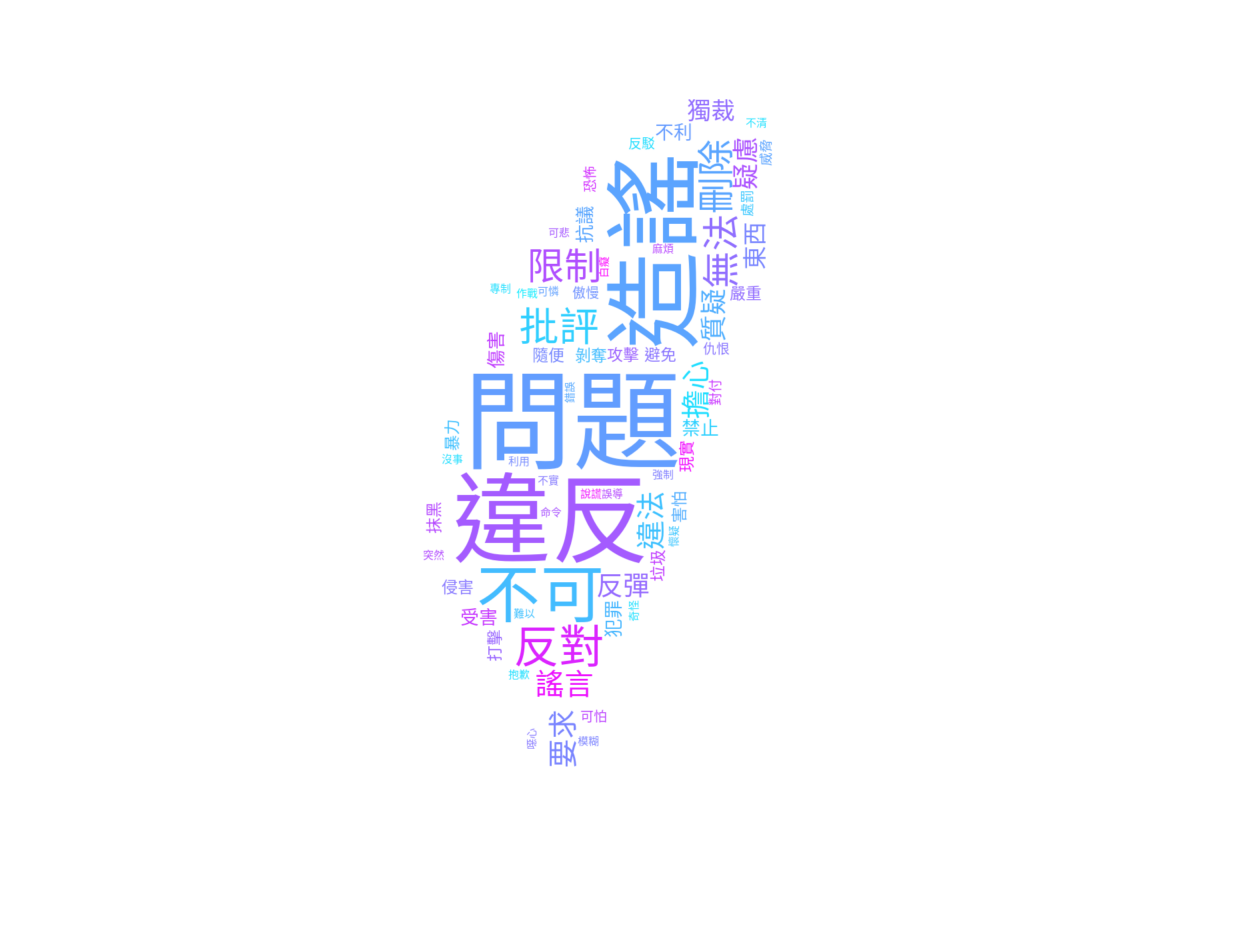

In [24]:
#負面
mask = (ptt_liwc_df["sentiments"] == "negative")

ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)
#遮罩
mask_tw = np.array(Image.open("./pic/taiwan_mask.jpg"))

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path, colormap="cool",
                  mask = mask_tw,width=2000, height = 1000)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(16, 8), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

負面詞彙文字雲中，常出現"造謠"、"違反"、"問題"、"違法"、"疑慮"、"質疑"、"不可"、"限制"等詞彙。也可見到"白癡"、"可悲"、"可怕"等詞彙。<br>
推測主要是對中介法案的憂心以及對該法案的不滿。

## 4. 留言(推噓文)內容分析(常見字詞、發文頻率、正負情緒分析、文字雲、情緒總量)

### 4.1 留言詞頻分析 
接著對留言內容進行分析，觀察相關文章留言中出現率最高的字詞

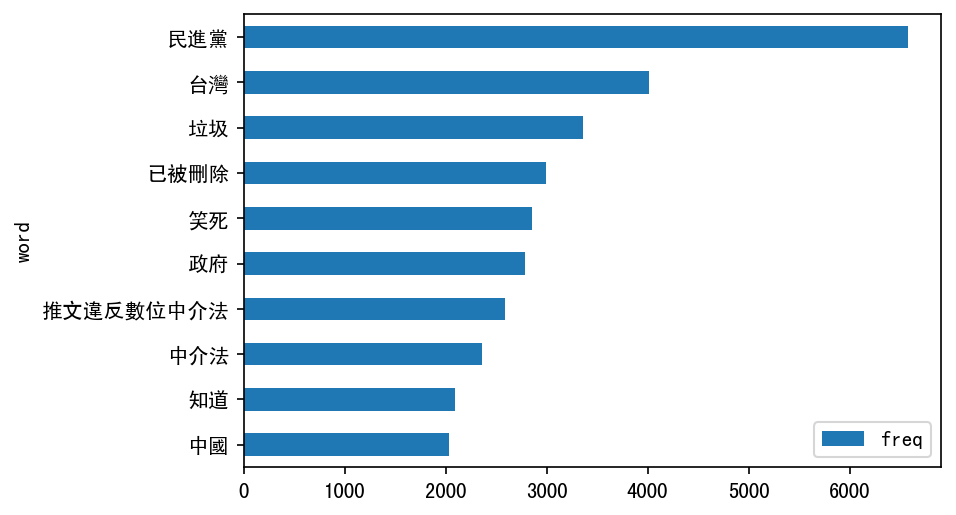

In [25]:
#留言詞頻
cm_freq_df = pd.DataFrame({'freq':noStop_cmdf.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)
cm_list = ['word','freq']
cm_freq_df = cm_freq_df[cm_list]
#依留言詞頻製圖
cm_freq_df.iloc[:10].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

由上圖可見，文章中最常出現的詞彙分別為與《數位中介服務法》相關的"中介法"、"已被刪除"；與法案推行相關的"政府"、"民進黨"等字。<br>
此外也有出現"中國"、"台灣"、"垃圾"、"笑死"等詞彙。

### 3.2 觀察留言頻率
透過觀察留言頻率以找出最多討論的時期。

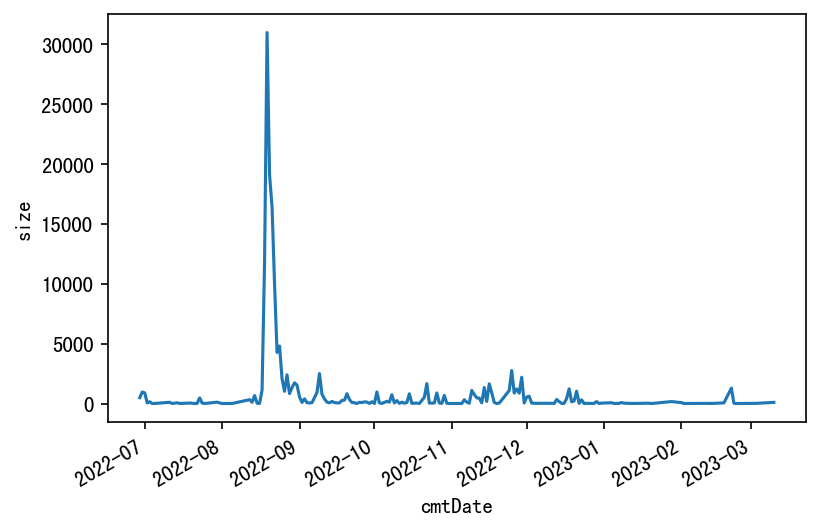

In [26]:
#各日相關文章推噓文數量
ptt_cmdf_date = cmdf.copy()
#只看日期，不抓時間
ptt_cmdf_date['cmtDate'] = pd.Series.to_frame(ptt_cmdf_date["cmtDate"])
ptt_cmdf_date["cmtDate"].describe(datetime_is_numeric=True)
ptt_cmdf_date["cmtDate"] = pd.to_datetime(ptt_cmdf_date["cmtDate"]).dt.date

ptt__cm_datefq_line_plot = ptt_cmdf_date.groupby(["cmtDate"], as_index=False).size()

fig, ax = plt.subplots()

#rolling_days = 14
ax.plot(ptt__cm_datefq_line_plot["cmtDate"], ptt__cm_datefq_line_plot["size"])
ax.set_xlabel("cmtDate")
ax.set_ylabel('size')
fig.autofmt_xdate()
plt.show()

由圖可見，最多留言同樣集中在2022年八月中左右。與前面的發文頻率圖相符合。

### 4.3 留言正負面情緒分數分析
透過正負面情緒分數來了解中介法相關議題下留言中的情緒。

In [27]:
#情緒字典與斷詞結果進行合併
ptt_cmdf_nostop = noStop_cmdf.copy()
ptt_cmdf_nostop['cmtDate'] = pd.Series.to_frame(ptt_cmdf_nostop['cmtDate'])
ptt_cmdf_nostop['cmtDate'].describe(datetime_is_numeric=True)
ptt_cmdf_nostop['cmtDate'] = pd.to_datetime(ptt_cmdf_nostop['cmtDate']).dt.date

#情緒字典與斷詞結果進行合併
ptt_liwc_cmdf = pd.merge(ptt_cmdf_nostop[["cmtDate", "word"]], df_liwc, how="left")

In [28]:
#計算每日正負面及中立字詞數
cm_sentiment_count = pd.DataFrame(
    ptt_liwc_cmdf.groupby(["cmtDate", "sentiments"], dropna=False, as_index=False).size()
)
cm_sentiment_count = cm_sentiment_count.rename(columns={0: "size"})
cm_sentiment_count = cm_sentiment_count.sort_values(["cmtDate"])

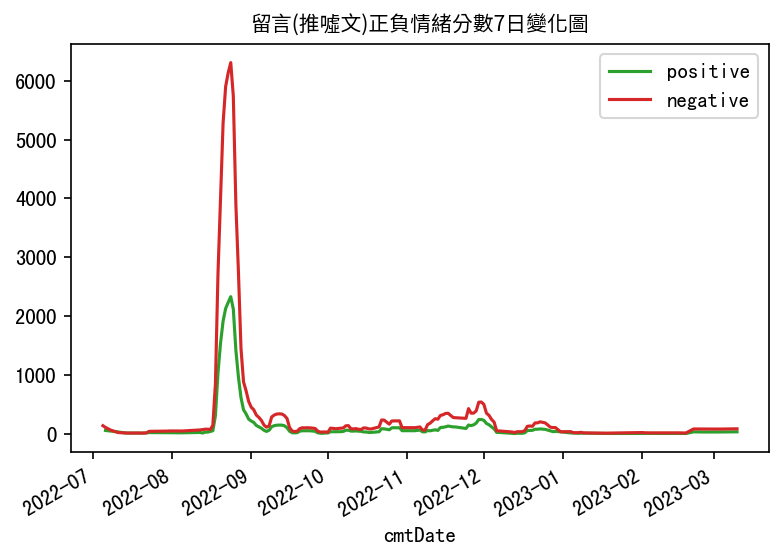

In [29]:
#依照上述內容繪製正負面情緒分數折線圖
colors = ["tab:green", "tab:red"]
pos = cm_sentiment_count[cm_sentiment_count["sentiments"] == "positive"]
neg = cm_sentiment_count[cm_sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()
rolling_days = 7
ax.plot(pos["cmtDate"], pos["size"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["cmtDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("cmtDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("留言(推噓文)正負情緒分數7日變化圖", 
          fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

由圖可見，負面情緒留言在8月中遠超過正面情緒留言。<br>
時間上符合第三場公開說明會期間、引起PTT大量討論的時間點。

In [29]:
#正負向情緒比例折線圖圖
cm_sentiment_count = cm_sentiment_count.assign(
    ratio=cm_sentiment_count.groupby("cmtDate")["size"].transform(lambda n: n / n.sum())
)
cm_sentiment_count

,cmtDate,sentiments,size,ratio
0,2022-06-29,negative,210,0.131910
1,2022-06-29,positive,80,0.050251
2,2022-06-29,NaN,1302,0.817839
3,2022-06-30,negative,325,0.105451
4,2022-06-30,positive,137,0.044452
...,...,...,...,...
494,2023-03-03,negative,4,0.111111
496,2023-03-03,NaN,28,0.777778
498,2023-03-10,positive,23,0.069277
497,2023-03-10,negative,38,0.114458


Text(0.5, 1.0, '留言(推噓文)正負情緒比例折線圖')

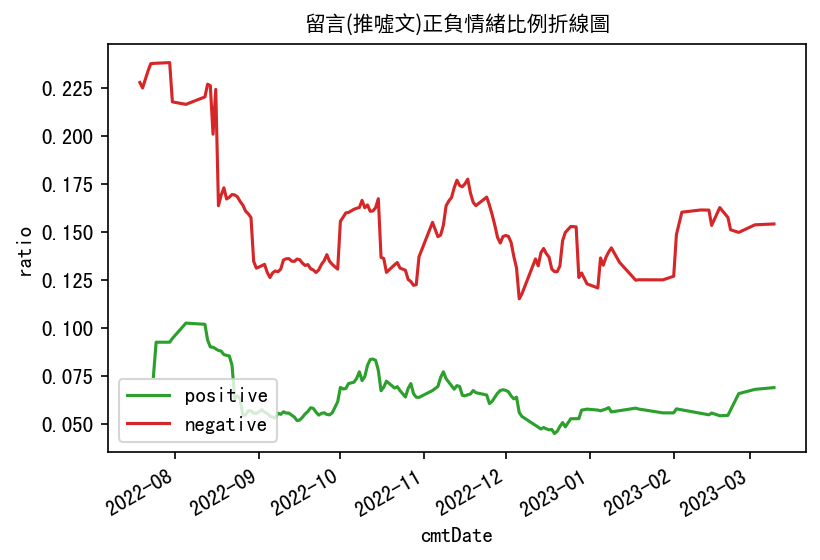

In [31]:
colors = ["tab:green", "tab:red"]
pos = cm_sentiment_count[cm_sentiment_count["sentiments"] == "positive"]
neg = cm_sentiment_count[cm_sentiment_count["sentiments"] == "negative"]
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["cmtDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["cmtDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("cmtDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("留言(推噓文)正負情緒比例折線圖", fontproperties=fprop)

由圖可見，留言的負面情緒比例遠勝過正面情緒比例。且並沒有發生交錯。顯示對該法案態度多為負面且態度一致。

### 4.4 留言文字雲

接著透過文字雲分析留言內容及常出現的正負面情緒詞彙

In [30]:
#擷取正面
mask = cm_sentiment_count['sentiments'] == 'positive'
cm_sentiment_count.loc[mask,:].sort_values("size", ascending=False).head()

,cmtDate,sentiments,size,ratio
83,2022-08-19,positive,5067,0.055915
86,2022-08-20,positive,3607,0.060091
89,2022-08-21,positive,2628,0.051414
80,2022-08-18,positive,1803,0.050792
92,2022-08-22,positive,1628,0.051701


In [31]:
#擷取負面
mask = cm_sentiment_count['sentiments'] == 'negative'
cm_sentiment_count.loc[mask,:].sort_values("size", ascending=False).head()

,cmtDate,sentiments,size,ratio
82,2022-08-19,negative,13187,0.145521
88,2022-08-21,negative,9424,0.184372
85,2022-08-20,negative,8864,0.147669
79,2022-08-18,negative,4912,0.138374
91,2022-08-22,negative,4381,0.139128


同樣聚焦8/18~8/22最多討論的期間進行分析。

In [32]:
#選擇討論最多的時間
mask = ((ptt_liwc_cmdf['cmtDate'] == pd.Timestamp("2022-08-18"))|
        (ptt_liwc_cmdf['cmtDate'] == pd.Timestamp("2022-08-19"))|
        (ptt_liwc_cmdf['cmtDate'] == pd.Timestamp("2022-08-20"))|
        (ptt_liwc_cmdf['cmtDate'] == pd.Timestamp("2022-08-21"))|
        (ptt_liwc_cmdf['cmtDate'] == pd.Timestamp("2022-08-22")))

ptt_liwc_cmdf = ptt_liwc_cmdf.loc[mask, ["cmtDate", "word", "sentiments"]]

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


(-0.5, 1811.5, 1359.5, -0.5)

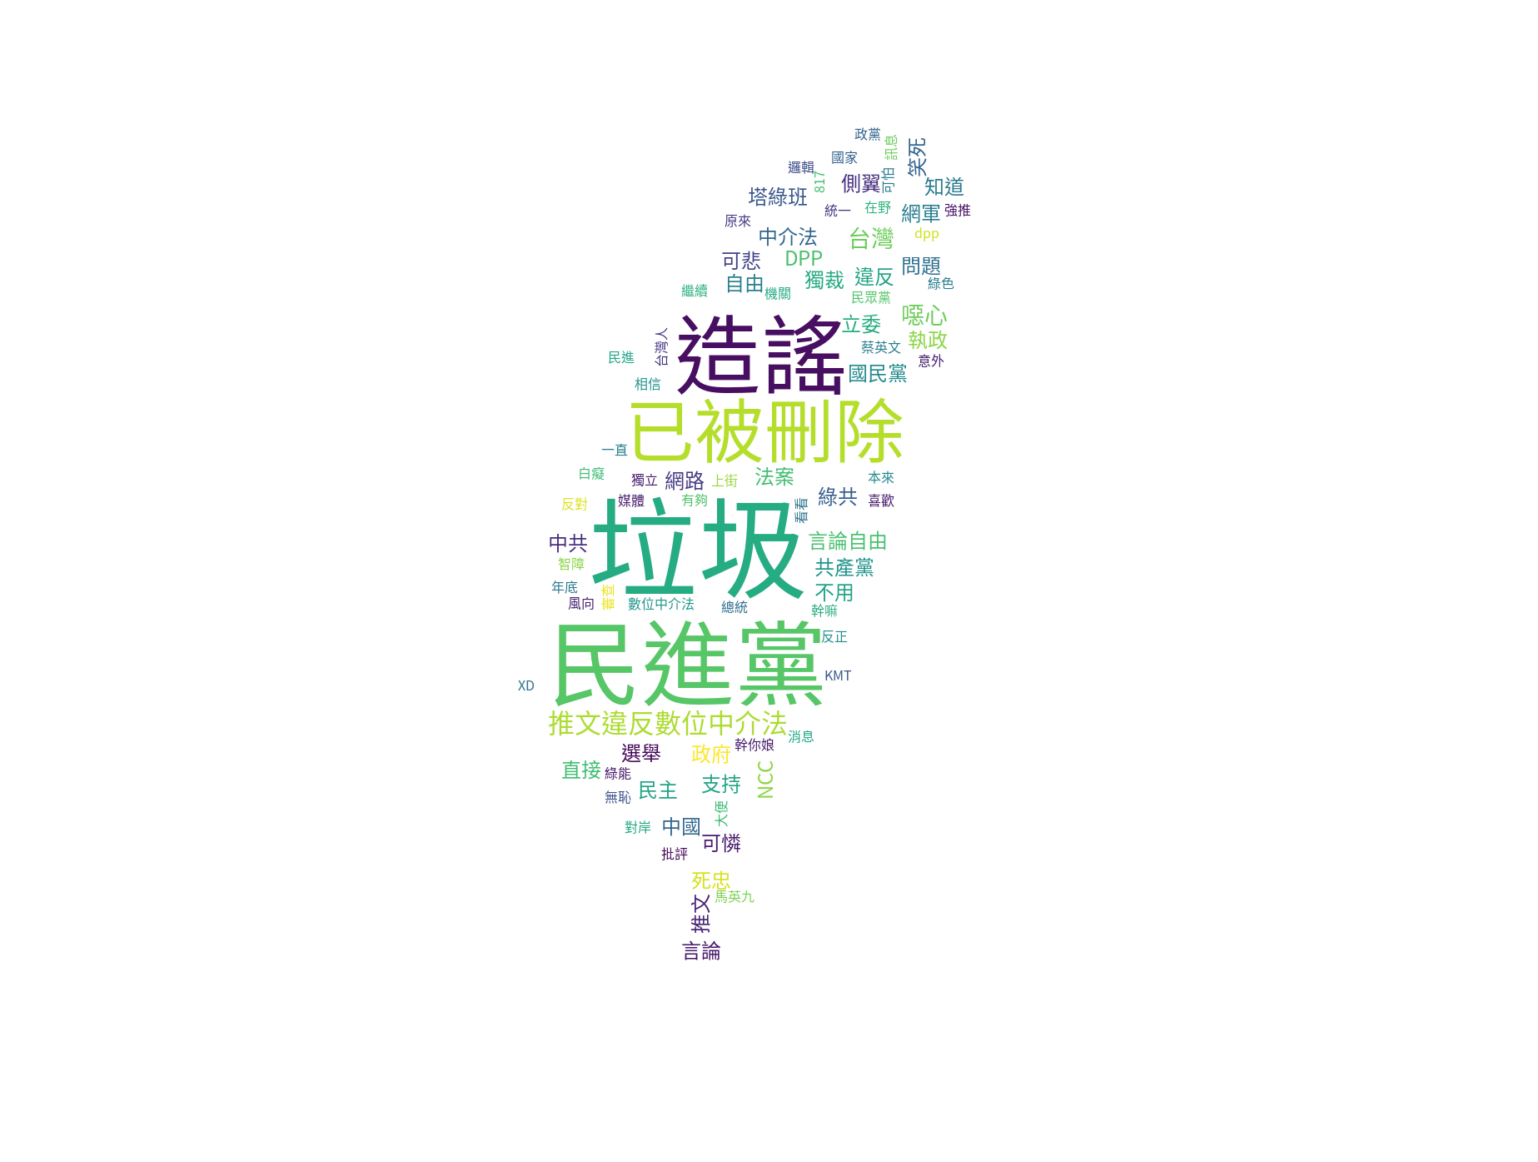

In [33]:
#繪製文字雲
wc = ptt_liwc_cmdf.groupby(["word"]).size().to_dict()
#自訂文字雲圖形
mask_tw = np.array(Image.open("./pic/taiwan_mask.jpg"))

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(scale = 4, max_words=100, background_color="white", font_path=font_path,mask = mask_tw, 
                  width = 1600, height = 800)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(20, 10), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

由文字雲可見，除了《數位中介服務法》相關的字詞外，還出現了大量如"塔綠班"、"綠共"、"死忠"、"側翼"、
"817"(指2016年總統大選民主進步黨得票數為817萬，用以代稱其支持者)等嘲諷執政黨及其支持者的字詞。


(-0.5, 1811.5, 1359.5, -0.5)

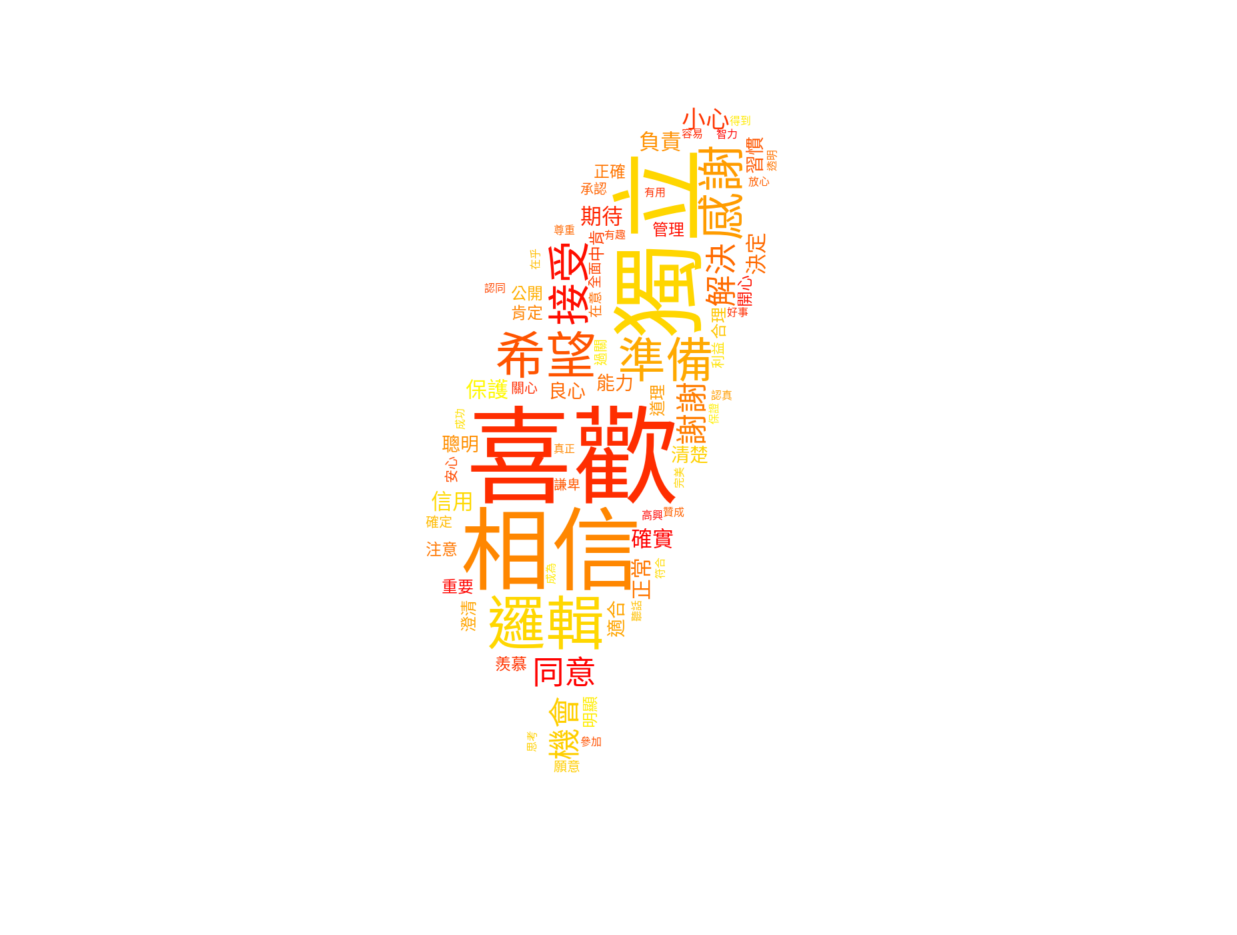

In [34]:
#正面
mask = (ptt_liwc_cmdf["sentiments"] == "positive")

ptt_df_wc = ptt_liwc_cmdf.loc[mask, ["cmtDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(50)


mask_tw = np.array(Image.open("./pic/taiwan_mask.jpg"))

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path, colormap="autumn",
                  mask = mask_tw,width=2000, height = 1000)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(16, 8), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()


In [ ]:
#負面
mask = (ptt_liwc_cmdf["sentiments"] == "negative")

ptt_df_wc = ptt_liwc_cmdf.loc[mask, ["cmtDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(50)
#遮罩
mask_tw = np.array(Image.open("./pic/taiwan_mask.jpg"))

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path, colormap="cool",
                  mask = mask_tw,width=2000, height = 1000)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(16, 8), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()


(-0.5, 1811.5, 1359.5, -0.5)

由負面情緒文字雲中可見，留言中常見的負面字詞有"垃圾"、"噁心"、"造謠"、"獨裁"、"無恥"、"問題"、"可憐"、"可悲"，也出現"他媽的"、"白癡"、"智障"等更強烈的用詞。

### 4.5 留言正負面情緒總量及代表字
透過情緒總量及代表字來更好的了解留言的情緒及常用字。

In [38]:
#推文正負面情緒總量
word_count = ptt_liwc_cmdf.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

In [39]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

In [40]:
word_of_neg.sort_values(["size"], ascending=False)

,word,sentiments,size
510,垃圾,negative,4032
2010,造謠,negative,3248
475,噁心,negative,2020
2038,違反,negative,1426
458,問題,negative,1186
...,...,...,...
2122,隱蔽,negative,1
566,天殺的,negative,1
2067,醜的,negative,1
2065,酸味,negative,1


Text(0.5, 1.0, '負向情緒總數')

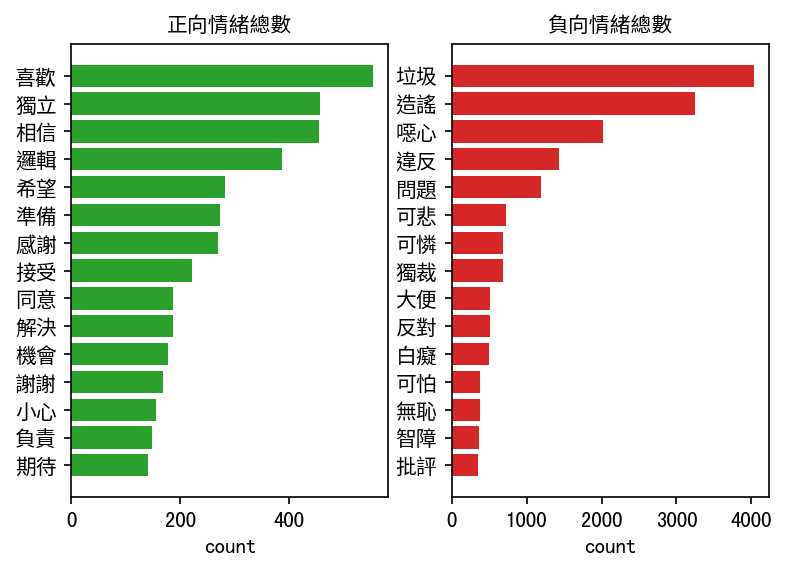

In [41]:
pos = word_of_pos.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]
neg = word_of_neg.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

正負面情緒字詞加總後進行比較，可以見到負面情緒壓倒性的勝過正面情緒，顯示留言對中介法相關內容的不滿。<br>
負面情緒以"垃圾"為代表字，經觀察資料後推測為對民進黨或對該法案相關的政府機關機關的不滿。

- 將每日正負面情緒總量繪製成圖

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


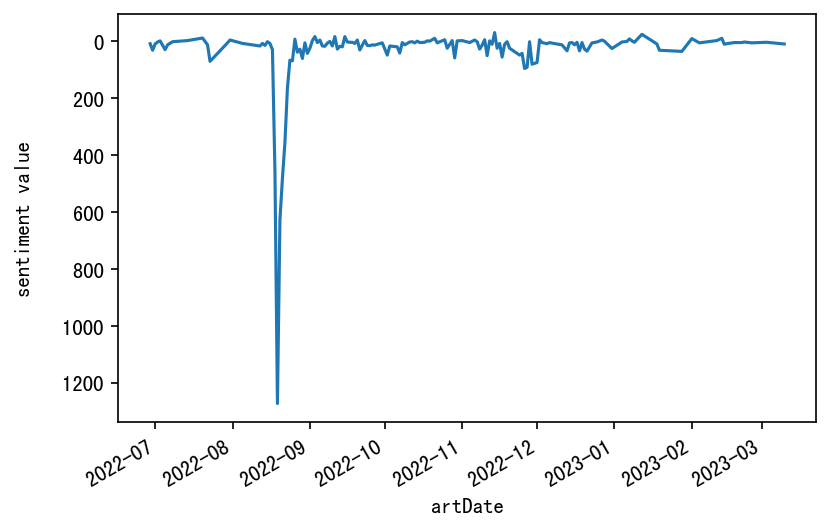

In [42]:
sentiment_count[sentiment_count["sentiments"] == "negative"].sort_values('size', ascending=False)
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)

fig, ax = plt.subplots()


ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"])
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()

## 5. 大量噓文文章相關分析
- PTT的推噓文系統，使我們可以大略得知該文章受歡迎與否。<br>
- 在觀察資料時，我們好奇被大量噓文的文章內容以及留言內容為何，故有以下分析<br>

In [43]:
#找出大量噓文的文章
ptt_badcmt = cmdf
bad_cmt = pd.DataFrame()

#計算噓文數-推文數，找出噓>推的文章，箭頭忽略不計。
for course, group in tqdm(ptt_badcmt.groupby('system_id')):
    tmp = group[['system_id','cmtDate']]
    cmt_count = pd.DataFrame(group['cmtStatus'].value_counts()) 
    cmt_diff = cmt_count[cmt_count.index=='噓'].values - cmt_count[cmt_count.index=='推'].values
    if cmt_diff > 0:
        tmp['diff'] = [cmt_diff][0][0][0]
    bad_cmt = bad_cmt.append(tmp)

  0%|                                                                                         | 0/1736 [00:00<?, ?it/s]C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
100%|█████████████████████████████████████████████████████████████████████████████| 1736/1736 [00:05<00:00, 330.30it/s]


In [44]:
#找出噓文數-推文數 >= 200文章的system_id
bad_cmt = bad_cmt.dropna(subset=['diff']).sort_values(by='diff',ascending=False)
bad_cmt_id = ((bad_cmt[bad_cmt['diff']>=200])['system_id']).to_frame()
bad_cmt_id = bad_cmt_id['system_id'].value_counts()
bad_cmt_id

mask = ((noStop_df['system_id'] == 592)|(noStop_df['system_id'] == 780)|(noStop_df['system_id'] == 813)|
        (noStop_df['system_id'] == 1303)|(noStop_df['system_id'] == 440)|(noStop_df['system_id'] == 1313)|
        (noStop_df['system_id'] == 1296)|(noStop_df['system_id'] == 1008))

#找出內文並結合情緒字典
ptt_worst_art = noStop_df.loc[mask, ["artDate", "word"]]
ptt_liwc_worst_art = pd.merge(ptt_worst_art[["artDate", "word"]], df_liwc, how="left")

#### 內文文字雲

(-0.5, 6399.5, 3199.5, -0.5)

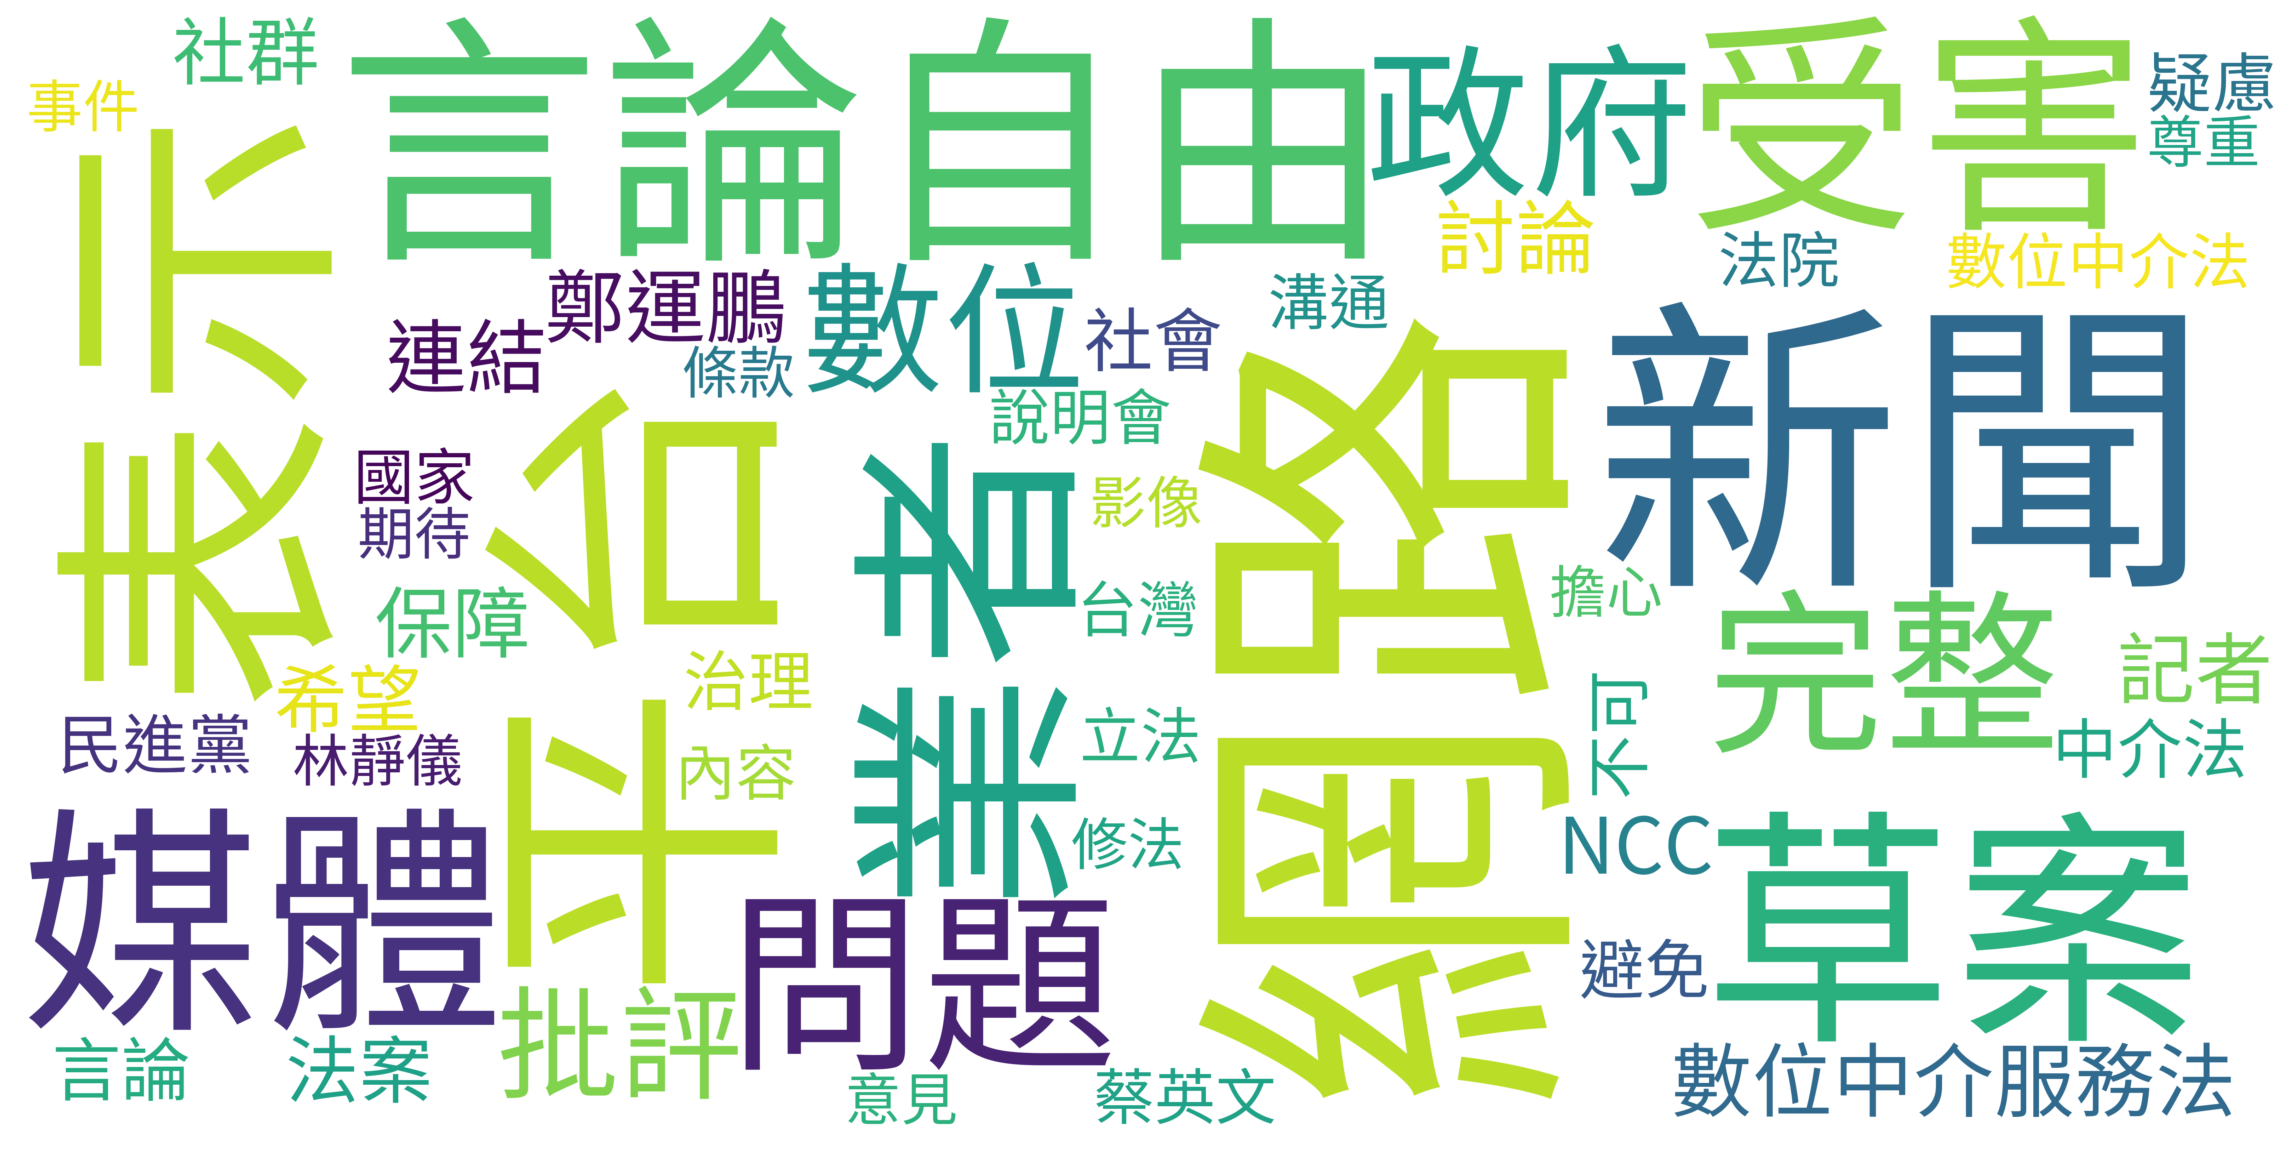

In [45]:
#繪製文字雲
wc = ptt_liwc_worst_art.groupby(["word"]).size().to_dict()

font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(scale = 4, max_words=50, background_color="white", font_path=font_path, 
                  width = 1600, height = 800)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(20, 10), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

- 由文字雲可見，大部分內容與8/18~8/22產生的內文文字雲相似，但出現了"鄭運鵬"、"林靜儀"兩個人名。
- 經查閱資料後，發現與兩位有關的標題為:<br>
    [新聞] 談中介法 鄭運鵬:絕對不會影響大家言論自由<br>
    [新聞] 「數位中介法」爆民怨 鄭運鵬：若大家不喜歡，可以再討論<br>
    [新聞] 談數位中介法批評聲浪 林靜儀：一邊罵政府詐騙集團猖獗 一邊不讓政府立法<br>
- 三篇文章皆引起網友大量不滿，鄭運鵬一個人就兩篇。厲害了老哥。

#### 留言文字雲

In [46]:
mask = ((noStop_cmdf['system_id'] == 592)|(noStop_cmdf['system_id'] == 780)|(noStop_cmdf['system_id'] == 813)|
        (noStop_cmdf['system_id'] == 1303)|(noStop_cmdf['system_id'] == 440)|(noStop_cmdf['system_id'] == 1313)|
        (noStop_cmdf['system_id'] == 1296)|(noStop_cmdf['system_id'] == 1008))

#找出留言並結合情緒字典
ptt_worst_cmt = noStop_cmdf.loc[mask, ["cmtDate", "word"]]
ptt_liwc_worst_cmt = pd.merge(ptt_worst_cmt[["cmtDate", "word"]], df_liwc, how="left")

(-0.5, 6399.5, 3199.5, -0.5)

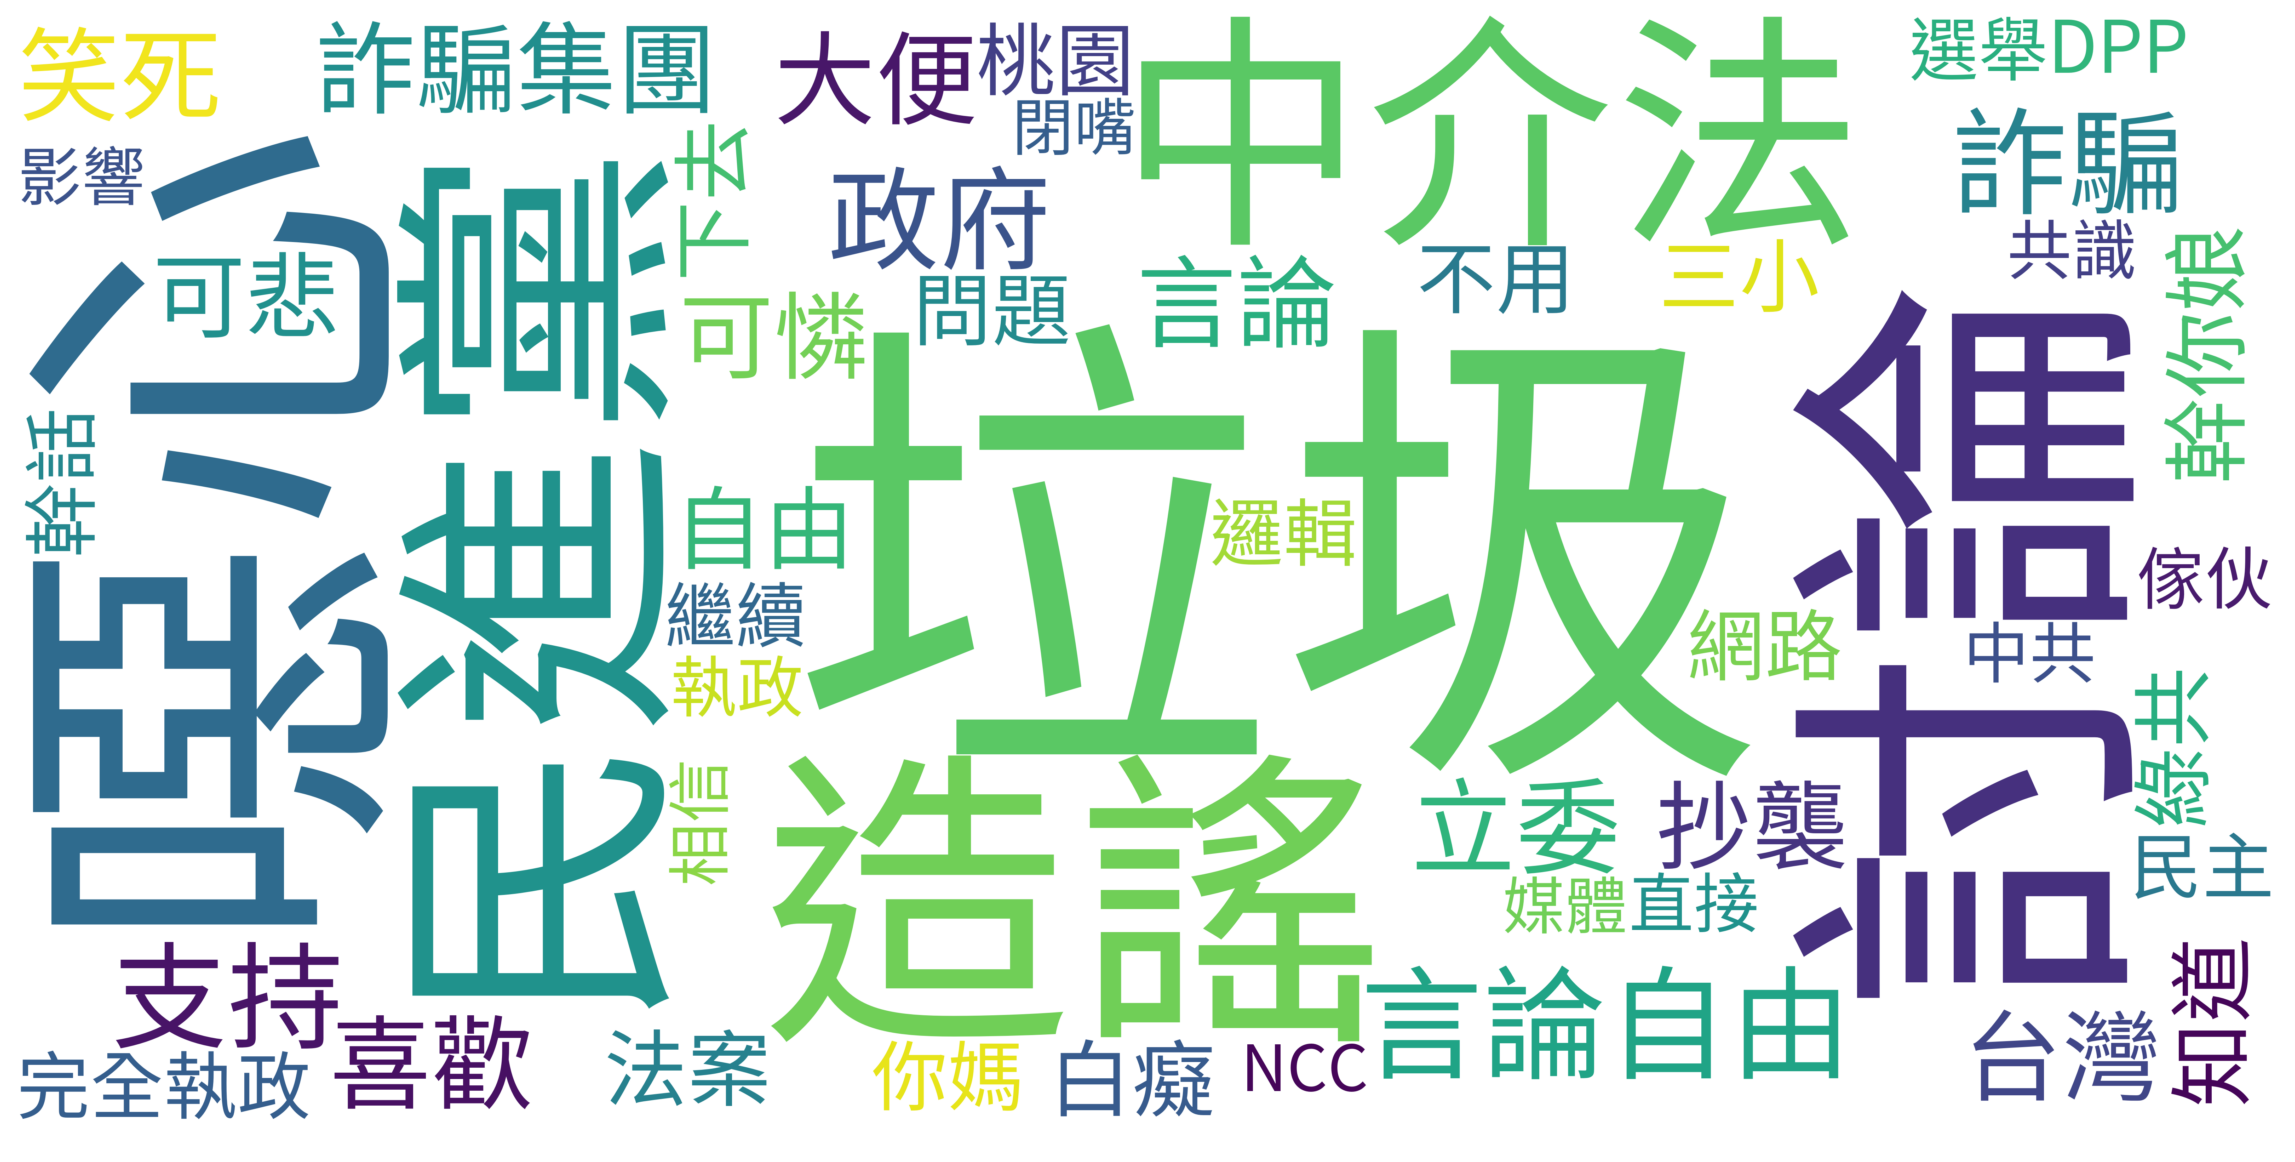

In [47]:
wc = ptt_liwc_worst_cmt.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(scale = 4, max_words=50, background_color="white", font_path=font_path, 
                  width = 1600, height = 800)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(20, 10), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

- 而留言文字雲除了大量負面情緒字詞外，也出現了"桃園"、"立委"等字詞。推測是因為鄭運鵬當時為桃園市市長參選人，故"桃園"一詞被大量討論。<br>
  而林靜儀當時是民進黨立委，所以"立委"一詞也出現在文字雲中。

## 6. 結論

- 在《數位中介服務法》8/18的第三場公開說明會後，PTT站方表示該法案相當於逼PTT關站，再加上另一網路論壇-巴哈姆特站長也對該法案表示反對態度，進而使PTT上討論爆發式增長。
- PTT八卦版友從頭到尾都對《數位中介服務法》抱持著負面態度，而當時對執政黨做為的普遍不滿，再加上當時對執政黨多次在PTT上帶風向。上述的多樣不滿使得出現大量抨擊及嘲諷執政黨的內文及留言。
- PTT八卦版友對《數位中介服務法》態度從一而終，沒有發生風向轉變的情況。